In [1]:
import tensorflow as tf
import numpy as np
import os

In [2]:
from tensorflow.keras.layers import Embedding, Input, Dropout, Dense, Activation, Reshape, LayerNormalization, Concatenate
from tensorflow.keras.models import Model

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer,tokenizer_from_json

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [5]:
import json

In [6]:
from datasets import load_dataset

In [7]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [8]:
ds=load_dataset("checkai/instruction-poems")

Found cached dataset parquet (C:/Users/Sagar/.cache/huggingface/datasets/checkai___parquet/checkai--instruction-poems-1b3e2aac01d64583/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
input_sequences = []
output_sequences = []
for item in ds['train']:
    if len(item['INSTRUCTION'])<=100 and len(item['RESPONSE'])<=500:
        input_sequences.append(item['INSTRUCTION'])
        output_sequences.append(item['RESPONSE'])

print(len(input_sequences),len(output_sequences))

1202 1202


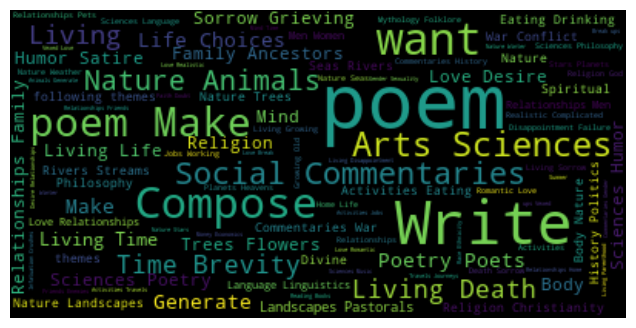

In [10]:
# DataSet Creation and Visualization 'INSTRUCTION'
wordcloud = WordCloud(
    max_font_size=50,
    max_words=200,
    background_color="black",
).generate(" ".join(input_sequences))

# Plotting the visualization
plt.figure(figsize=(8,4))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

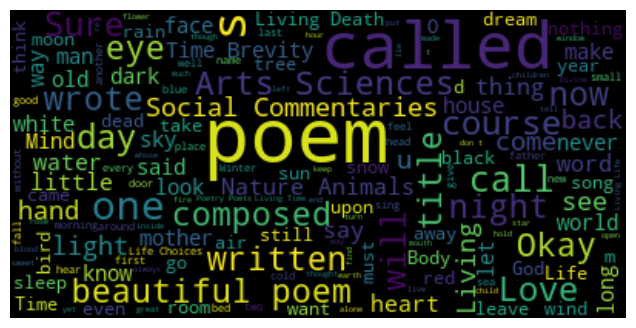

In [11]:
# DataSet Creation and Visualization 'INSTRUCTION'
wordcloud = WordCloud(
    max_font_size=50,
    max_words=200,
    background_color="black",
).generate(" ".join(output_sequences))

# Plotting the visualization
plt.figure(figsize=(8,4))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

In [12]:
# Generating the corpus by splitting the text into lines
# qq is the new next line token
input_sequences_treated = [sentence.lower().replace("\n"," qq ") for sentence in input_sequences]
input_sequences_treated = [sentence.lower().replace("\r"," qq ") for sentence in input_sequences_treated]
input_sequences_treated = [sentence.lower().replace("\u2009-","") for sentence in input_sequences_treated]
input_sequences_treated = [sentence.lower().replace("\u2009","") for sentence in input_sequences_treated]
input_sequences_treated = [sentence.lower().replace("\u200a","") for sentence in input_sequences_treated]
input_sequences_treated = [sentence.lower().replace("\"","") for sentence in input_sequences_treated]
input_sequences_treated = [sentence.lower().replace("\'","") for sentence in input_sequences_treated]
input_sequences_treated = [sentence.lower().replace("&","and") for sentence in input_sequences_treated]
input_sequences_treated = ["soq " + sentence + " eoq" for sentence in input_sequences_treated]

output_sequences_treated = [sentence.lower().replace("\n"," qq ") for sentence in output_sequences]
output_sequences_treated = [sentence.lower().replace("\r"," qq ") for sentence in output_sequences_treated]
output_sequences_treated = [sentence.lower().replace("\u2009-","") for sentence in output_sequences_treated]
output_sequences_treated = [sentence.lower().replace("\u2009","") for sentence in output_sequences_treated]
output_sequences_treated = [sentence.lower().replace("\u200a","") for sentence in output_sequences_treated]
output_sequences_treated = [sentence.lower().replace("\"","") for sentence in output_sequences_treated]
output_sequences_treated = [sentence.lower().replace("\'","") for sentence in output_sequences_treated]
output_sequences_treated = [sentence.lower().replace("&","and") for sentence in output_sequences_treated]
output_sequences_treated = [" soa " + sentence + " eoa " for sentence in output_sequences_treated]

In [13]:
# Building the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(input_sequences_treated+output_sequences_treated)

# Vocabulary count of the corpus
total_words = len(tokenizer.word_index)

print("Total Words:", total_words)

Total Words: 10800


In [14]:
# Save Tokenizer
tokenizer_json = tokenizer.to_json()
if not os.path.exists('./tokenizers/'):
    os.makedirs('./tokenizers/')
with open('./tokenizers/tokenizer.json', 'w', encoding='utf-8') as file:
    file.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [15]:
# Load Tokenizers
with open('./tokenizers/tokenizer.json') as file:
    data_json = json.load(file)
    tokenizer = tokenizer_from_json(data_json)

In [17]:
for i in range(len(input_sequences_treated)):
    with open("poems.txt",encoding='utf8',mode="a") as file:
        print(input_sequences_treated[i],file=file,end="")
        print(output_sequences_treated[i],file=file,end="")

In [18]:
corpus = open('poems.txt',encoding='utf8').read()

In [19]:
token_list = tokenizer.texts_to_sequences([corpus])[0]

def data_loader(index=0):
    # Define block size
    block_size = 50
    count=0
    # Creating inputs
    input_sequence = []
    input_padding = []
    output_sequence = []
    padding=np.ones((block_size,))
    while(True):
        for i in range(len(token_list)):
            for j in range(i+1,i+block_size+1):
                if j+1<=len(token_list):
                    count+=1
                    n_gram_sequence_input = token_list[i:j]
                    n_gram_sequence_output = token_list[i+1:j+1]
                    n_gram_sequence_padding = padding[:j-i]
                    input_sequence.append(n_gram_sequence_input)
                    output_sequence.append(n_gram_sequence_output)
                    input_padding.append(n_gram_sequence_padding)
                if count>=32:
                        input_sequence_padded=np.array(pad_sequences(
                            input_sequence,
                            maxlen=block_size,
                            padding='pre'
                        ))
                        input_padding_padded=np.array(pad_sequences(
                            input_padding,
                            maxlen=block_size,
                            padding='pre'
                        )).reshape(-1,1,1,block_size)
                        output_sequence_padded=np.array(pad_sequences(
                            output_sequence,
                            maxlen=block_size,
                            padding='pre'
                        ))
                        count=0
                        input_sequence = []
                        input_padding = []
                        output_sequence = []
                        yield ((input_sequence_padded,input_padding_padded),output_sequence_padded)

In [25]:
class Transformer():
    def __init__(self,
            input_sequence_length=50,
            output_sequence_length=50,
            d_model=256,
            src_vocab_size=3800,
            trg_vocab_size=3800,
            n_blocks_encoder=4,
            n_blocks_decoder=6,
            n_heads=4,
            layer1_units_ff=1024,
            layer2_units_ff=256,
            dropout_rate=0.1
        ):

        self.input_sequence_length=input_sequence_length
        self.output_sequence_length=output_sequence_length
        self.d_model=d_model
        self.src_vocab_size=src_vocab_size
        self.trg_vocab_size=trg_vocab_size
        self.n_blocks_encoder=n_blocks_encoder
        self.n_blocks_decoder=n_blocks_decoder
        self.n_heads=n_heads
        self.layer1_units_ff=layer1_units_ff
        self.layer2_units_ff=layer2_units_ff
        self.dropout_rate=dropout_rate

        self.input_shape_encoder=(input_sequence_length,)
        self.input_shape_decoder=(output_sequence_length,)
        self.intermediate_shape_encoder=(input_sequence_length,d_model)
        self.intermediate_shape_decoder=(output_sequence_length,d_model)
        self.mask_shape_encoder=(1,1,input_sequence_length)
        self.mask_shape_decoder=(1,1,output_sequence_length)

    def EncoderSequenceEmbedding(self,
            input_shape=None,
            d_model=None,
            vocab_size=None,
            dropout_rate=None,
            initializers=None
        ):

        if input_shape is None:
            input_shape=self.input_shape_encoder
        if d_model is None:
            d_model=self.d_model
        if vocab_size is None:
            vocab_size=self.src_vocab_size
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
        if initializers is None:
            initializers=tf.keras.initializers.glorot_uniform(seed=1)

        sequence_length = input_shape[0]
        # Create matrix of shape (seq_len,d_model)
        positionalEncoding = np.zeros((sequence_length,d_model))
        # Create vector of shape (seq_len,1)
        position = np.arange(0,sequence_length).reshape(-1,1)
        # Create denominator of shape (1,d_model)
        div_term = np.exp(np.arange(0,d_model,2)*(-np.log(10000.0)/d_model)).reshape(1,-1)
        # Apply sin to even positions and cos to odd positions
        positionalEncoding[:,0::2] = np.sin(position*div_term)
        positionalEncoding[:,1::2] = np.cos(position*div_term)
        # Reshape to (1,seq_len,)
        positionalEncoding = positionalEncoding.reshape(1,sequence_length,d_model)

        # Model Architecture
        input = Input(shape=input_shape,name="Encoder_EmbeddingLayer_Input")

        # Create Input Embedding Layer
        x = Embedding(vocab_size,d_model,embeddings_initializer=initializers,name="Input_Embedding_Encoder")(input)
        x = x/np.sqrt(d_model)

        # Add Positional Embedding
        x = x + positionalEncoding[:,:x.shape[1],:]
        
        # Dropout
        x = Dropout(rate=dropout_rate,name="Encoder_Input_Dropout")(x)

        model = Model(inputs=[input],outputs=[x],name="EncoderSequenceEmbedding")

        return model
    
    def DecoderSequenceEmbedding(self,
            input_shape=None,
            d_model=None,
            vocab_size=None,
            dropout_rate=None,
            initializers=None
        ):

        if input_shape is None:
            input_shape=self.input_shape_decoder
        if d_model is None:
            d_model=self.d_model
        if vocab_size is None:
            vocab_size=self.trg_vocab_size
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
        if initializers is None:
            initializers=tf.keras.initializers.glorot_uniform(seed=1)

        sequence_length = input_shape[0]
        # Create matrix of shape (seq_len,d_model)
        positionalEncoding = np.zeros((sequence_length,d_model))
        # Create vector of shape (seq_len,1)
        position = np.arange(0,sequence_length).reshape(-1,1)
        # Create denominator of shape (1,d_model)
        div_term = np.exp(np.arange(0,d_model,2)*(-np.log(10000.0)/d_model)).reshape(1,-1)
        # Apply sin to even positions and cos to odd positions
        positionalEncoding[:,0::2] = np.sin(position*div_term)
        positionalEncoding[:,1::2] = np.cos(position*div_term)
        # Reshape to (1,seq_len,)
        positionalEncoding = positionalEncoding.reshape(1,sequence_length,d_model)

        # Model Architecture
        input = Input(shape=input_shape,name="Decoder_EmbeddingLayer_Input")

        # Create Input Embedding Layer
        x = Embedding(vocab_size,d_model,embeddings_initializer=initializers,name="Input_Embedding_Decoder")(input)
        x = x/np.sqrt(d_model)

        # Add Positional Embedding
        x = x + positionalEncoding[:,:x.shape[1],:]
        
        # Dropout
        x = Dropout(rate=dropout_rate,name="Decoder_Input_Dropout")(x)

        model = Model(inputs=[input],outputs=[x],name="DecoderSequenceEmbedding")

        return model
    
    def EncoderMultiHeadAttention(self,
            input_shape_query=None,
            input_shape_key=None,
            input_shape_value=None,
            mask_shape=None,
            d_model=None,
            heads=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape_query is None:
            input_shape_query=self.intermediate_shape_encoder
        if input_shape_key is None:
            input_shape_key=self.intermediate_shape_encoder
        if input_shape_value is None:
            input_shape_value=self.intermediate_shape_encoder
        if mask_shape is None:
            mask_shape=self.mask_shape_encoder
        if d_model is None:
            d_model=self.d_model
        if heads is None:
            heads=self.n_heads
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
    
        d_k = d_model // heads

        # Define mask
        mask = Input(shape=mask_shape,name=f"EMHAInput_mask_{index}")
        # Define key, query and value
        query_input = Input(shape=input_shape_query,name=f"EMultiHeadAttention_query_Input_{index}")
        key_input = Input(shape=input_shape_key,name=f"EMultiHeadAttention_key_Input_{index}")
        value_input = Input(shape=input_shape_value,name=f"EMultiHeadAttention_value_Input_{index}")

        query = Dense(d_model,name=f"EQuery_Creator_{index}",)(query_input)
        key = Dense(d_model,name=f"EKey_Creator_{index}")(key_input)
        value = Dense(d_model,name=f"EValue_Creator_{index}")(value_input)

        query = Reshape((query.shape[1],heads,d_k),name=f"EQuery_reshaper_{index}")(query)
        query = tf.transpose(query,perm=[0,2,1,3],name=f"EQuery_transposer_{index}")

        key = Reshape((key.shape[1],heads,d_k),name=f"EKey_reshaper_{index}")(key)
        key = tf.transpose(key,perm=[0,2,1,3])
        key = tf.transpose(key,perm=[0,1,3,2])

        value = Reshape((value.shape[1],heads,d_k),name=f"EValue_reshaper_{index}")(value)
        value = tf.transpose(value,perm=[0,2,1,3])

        attention_scores = (query @ key)/np.sqrt(d_k)

        if mask is not None:
            attention_scores = attention_scores*mask
            neg_inf=tf.cast((mask==0),dtype=tf.float32)*(-np.exp(4*np.log(10)))
            attention_scores += neg_inf
        attention_scores = tf.nn.softmax(attention_scores,axis=-1)
        if dropout_rate is not None:
            attention_scores = Dropout(rate=dropout_rate,name=f"EMultiHeadAttention_dropout_{index}")(attention_scores)
        
        x = attention_scores @ value
        x = tf.transpose(x,perm=[0,2,1,3])
        x = Reshape((x.shape[1],x.shape[2]*x.shape[3]),name=f"EOutput_reshaper_{index}")(x)

        x = Dense(d_model,name=f"EOutput_creator_{index}")(x)
        
        model = Model(inputs=[query_input,key_input,value_input,mask],outputs=[x,attention_scores],name=f"EncoderMultiHeadAttention_{index}")

        return model
    
    def DecoderMultiHeadAttention(self,
            input_shape_query=None,
            input_shape_key=None,
            input_shape_value=None,
            mask_shape=None,
            d_model=None,
            heads=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape_query is None:
            input_shape_query=self.intermediate_shape_decoder
        if input_shape_key is None:
            input_shape_key=self.intermediate_shape_decoder
        if input_shape_value is None:
            input_shape_value=self.intermediate_shape_decoder
        if mask_shape is None:
            mask_shape=self.mask_shape_decoder
        if d_model is None:
            d_model=self.d_model
        if heads is None:
            heads=self.n_heads
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
    
        d_k = d_model // heads

        # Define mask
        mask = Input(shape=mask_shape,name=f"DMHAInput_mask_{index}")
        # Define key, query and value
        query_input = Input(shape=input_shape_query,name=f"DMultiHeadAttention_query_Input_{index}")
        key_input = Input(shape=input_shape_key,name=f"DMultiHeadAttention_key_Input_{index}")
        value_input = Input(shape=input_shape_value,name=f"DMultiHeadAttention_value_Input_{index}")

        query = Dense(d_model,name=f"DQuery_Creator_{index}",)(query_input)
        key = Dense(d_model,name=f"DKey_Creator_{index}")(key_input)
        value = Dense(d_model,name=f"DValue_Creator_{index}")(value_input)

        query = Reshape((query.shape[1],heads,d_k),name=f"DQuery_reshaper_{index}")(query)
        query = tf.transpose(query,perm=[0,2,1,3],name=f"DQuery_transposer_{index}")

        key = Reshape((key.shape[1],heads,d_k),name=f"DKey_reshaper_{index}")(key)
        key = tf.transpose(key,perm=[0,2,1,3])
        key = tf.transpose(key,perm=[0,1,3,2])

        value = Reshape((value.shape[1],heads,d_k),name=f"DValue_reshaper_{index}")(value)
        value = tf.transpose(value,perm=[0,2,1,3])

        attention_scores = (query @ key)/np.sqrt(d_k)
        
        if mask is not None:
            attention_scores = attention_scores*mask
            neg_inf=tf.cast((mask==0),dtype=tf.float32)*(-np.exp(4*np.log(10)))
            attention_scores += neg_inf
        # Block future tokens from communicating to the past
        future_mask=np.triu(np.ones((1,1,attention_scores.shape[-2],attention_scores.shape[-1])))
        future_mask=(future_mask==0).astype(int)
        future_mask=future_mask/(np.sum(future_mask,axis=-1,keepdims=True)+0.001)
        attention_scores = attention_scores*future_mask
        neg_inf=tf.cast((future_mask==0),dtype=tf.float32)*(-np.exp(4*np.log(10)))
        attention_scores += neg_inf
        # Softmax the attention scores
        attention_scores = tf.nn.softmax(attention_scores,axis=-1)
        if dropout_rate is not None:
            attention_scores = Dropout(rate=dropout_rate,name=f"DMultiHeadAttention_dropout_{index}")(attention_scores)
        
        x = attention_scores @ value
        x = tf.transpose(x,perm=[0,2,1,3])
        x = Reshape((x.shape[1],x.shape[2]*x.shape[3]),name=f"DOutput_reshaper_{index}")(x)

        x = Dense(d_model,name=f"DOutput_creator_{index}")(x)
        
        model = Model(inputs=[query_input,key_input,value_input,mask],outputs=[x,attention_scores],name=f"DecoderMultiHeadAttention_{index}")

        return model
    
    def CrossMultiHeadAttention(self,
            input_shape_query=None,
            input_shape_key=None,
            input_shape_value=None,
            mask_shape=None,
            d_model=None,
            heads=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape_query is None:
            input_shape_query=self.intermediate_shape_decoder
        if input_shape_key is None:
            input_shape_key=self.intermediate_shape_encoder
        if input_shape_value is None:
            input_shape_value=self.intermediate_shape_encoder
        if mask_shape is None:
            mask_shape=self.mask_shape_encoder
        if d_model is None:
            d_model=self.d_model
        if heads is None:
            heads=self.n_heads
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
    
        d_k = d_model // heads

        # Define mask
        mask = Input(shape=mask_shape,name=f"CMHAInput_mask_{index}")
        # Define key, query and value
        query_input = Input(shape=input_shape_query,name=f"CMultiHeadAttention_query_Input_{index}")
        key_input = Input(shape=input_shape_key,name=f"CMultiHeadAttention_key_Input_{index}")
        value_input = Input(shape=input_shape_value,name=f"CMultiHeadAttention_value_Input_{index}")

        query = Dense(d_model,name=f"CQuery_Creator_{index}",)(query_input)
        key = Dense(d_model,name=f"CKey_Creator_{index}")(key_input)
        value = Dense(d_model,name=f"CValue_Creator_{index}")(value_input)

        query = Reshape((query.shape[1],heads,d_k),name=f"CQuery_reshaper_{index}")(query)
        query = tf.transpose(query,perm=[0,2,1,3],name=f"CQuery_transposer_{index}")

        key = Reshape((key.shape[1],heads,d_k),name=f"CKey_reshaper_{index}")(key)
        key = tf.transpose(key,perm=[0,2,1,3])
        key = tf.transpose(key,perm=[0,1,3,2])

        value = Reshape((value.shape[1],heads,d_k),name=f"CValue_reshaper_{index}")(value)
        value = tf.transpose(value,perm=[0,2,1,3])

        attention_scores = (query @ key)/np.sqrt(d_k)

        if mask is not None:
            attention_scores = attention_scores*mask
            neg_inf=tf.cast((mask==0),dtype=tf.float32)*(-np.exp(4*np.log(10)))
            attention_scores += neg_inf
        attention_scores = tf.nn.softmax(attention_scores,axis=-1)
        if dropout_rate is not None:
            attention_scores = Dropout(rate=dropout_rate,name=f"CMultiHeadAttention_dropout_{index}")(attention_scores)
        
        x = attention_scores @ value
        x = tf.transpose(x,perm=[0,2,1,3])
        x = Reshape((x.shape[1],x.shape[2]*x.shape[3]),name=f"COutput_reshaper_{index}")(x)

        x = Dense(d_model,name=f"COutput_creator_{index}")(x)
        
        model = Model(inputs=[query_input,key_input,value_input,mask],outputs=[x,attention_scores],name=f"CrossMultiHeadAttention_{index}")

        return model
    
    def EncoderFeedForward(self,
            input_shape=None,
            layer1_units=None,
            layer2_units=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape is None:
            input_shape=self.intermediate_shape_encoder
        if layer1_units is None:
            layer1_units=self.layer1_units_ff
        if layer2_units is None:
            layer2_units=self.layer2_units_ff
        if dropout_rate is None:
            dropout_rate=self.dropout_rate

        # Pick up input
        input = Input(shape = input_shape,name=f"EFeedForwardInput_{index}")
        # First Dense layer
        x = Dense(layer1_units,name=f"EFeedForwardDense1_{index}")(input)
        # Relu activation
        x = Activation('relu',name=f"EFeedForwardRelu_{index}")(x)
        # Dropouts
        x = Dropout(dropout_rate,name=f"EFeedForwardDropout_{index}")(x)
        # Second Dense Layer
        x = Dense(layer2_units,name=f"EFeedForwardDense2_{index}")(x)

        model = Model(inputs=[input],outputs=[x],name=f"EncoderFeedForward_{index}")

        return model
    
    def DecoderFeedForward(self,
            input_shape=None,
            layer1_units=None,
            layer2_units=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape is None:
            input_shape=self.intermediate_shape_decoder
        if layer1_units is None:
            layer1_units=self.layer1_units_ff
        if layer2_units is None:
            layer2_units=self.layer2_units_ff
        if dropout_rate is None:
            dropout_rate=self.dropout_rate

        # Pick up input
        input = Input(shape = input_shape,name=f"DFeedForwardInput_{index}")
        # First Dense layer
        x = Dense(layer1_units,name=f"DFeedForwardDense1_{index}")(input)
        # Relu activation
        x = Activation('relu',name=f"DFeedForwardRelu_{index}")(x)
        # Dropouts
        x = Dropout(dropout_rate,name=f"DFeedForwardDropout_{index}")(x)
        # Second Dense Layer
        x = Dense(layer2_units,name=f"DFeedForwardDense2_{index}")(x)

        model = Model(inputs=[input],outputs=[x],name=f"DecoderFeedForward_{index}")

        return model

    def ResidualConnectionMHA(self,input,sub_layer,dropout_rate,index=0,flag=0):

        # Layer Normalization
        x = LayerNormalization(name=f"ResidualConnectionMHALayerNormalization_{index}_{flag}")(input)
        # MHA Layer
        [x, a] = sub_layer(x)
        # Dropouts
        x = Dropout(rate=dropout_rate,name=f"ResidualConnectionMHADropout_{index}_{flag}")(x)
        # Residual Connection
        x = input + x

        return x, a
    
    def ResidualConnectionFF(self,input,sub_layer,dropout_rate,index=0,flag=0):

        # Layer Normalization
        x = LayerNormalization(name=f"ResidualConnectionLayerNormalization_{index}_{flag}")(input)
        # FF Layer
        x = sub_layer(x)
        # Dropouts
        x = Dropout(rate=dropout_rate,name=f"ResidualConnectionDropout_{index}_{flag}")(x)
        # Residual Connection
        x = input + x

        return x
    
    def Encoderblock(self,
            input_shape=None,
            mask_shape=None,
            MultiHeadAttention_block=None,
            FeedForward_block=None,
            dropout_rate=None,
            index=0
        ):

        if input_shape is None:
            input_shape=self.intermediate_shape_encoder
        if mask_shape is None:
            mask_shape=self.mask_shape_encoder
        if MultiHeadAttention_block is None:
            MultiHeadAttention_block=self.EncoderMultiHeadAttention(index=index)
        if FeedForward_block is None:
            FeedForward_block=self.EncoderFeedForward(index=index)
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
    
        # Pick up input and mask 
        mask = Input(shape=mask_shape,name=f"EncoderblockMask_{index}")
        input = Input(shape=input_shape,name=f"EncoderblockInput_{index}")

        # MHA Block with residual connection
        x, a = self.ResidualConnectionMHA(input,lambda x: MultiHeadAttention_block([x, x, x, mask]),dropout_rate,index,0)
        # FF Block with residual connection
        x = self.ResidualConnectionFF(x,lambda x: FeedForward_block(x),dropout_rate,index,0)

        model = Model(inputs=[input,mask],outputs=[x,a],name=f"Encoderblock_{index}")

        return model
    
    def Encoder(self,
            input_shape=None,
            mask_shape=None,
            n_blocks=None,
            d_model=None,
            n_heads=None,
            layer1_units_ff=None,
            layer2_units_ff=None,
            dropout_rate=None
        ):

        if input_shape is None:
            input_shape=self.intermediate_shape_encoder
        if mask_shape is None:
            mask_shape=self.mask_shape_encoder
        if n_blocks is None:
            n_blocks=self.n_blocks_encoder
        if d_model is None:
            d_model=self.d_model
        if n_heads is None:
            n_heads=self.n_heads
        if layer1_units_ff is None:
            layer1_units_ff=self.layer1_units_ff
        if layer2_units_ff is None:
            layer2_units_ff=self.layer2_units_ff
        if dropout_rate is None:
            dropout_rate=self.dropout_rate

        # Pick up Encoder input and mask
        input = Input(shape=input_shape,name="Encoder_Input_E")
        mask = Input(shape=mask_shape,name="Encoder_Input_Mask_E")
        
        x = input
        # Attention outputs for visualization
        a_list = []
        # n_blocks Encoder Blocks
        for i in range(n_blocks):
            [x, a] = self.Encoderblock(
                        input_shape,
                        mask_shape,
                        self.EncoderMultiHeadAttention(
                            input_shape,
                            input_shape,
                            input_shape,
                            mask_shape,
                            d_model,
                            n_heads,
                            dropout_rate,
                            i
                        ),
                        self.EncoderFeedForward(
                            input_shape,
                            layer1_units_ff,
                            layer2_units_ff,
                            dropout_rate,
                            i
                        ),
                        dropout_rate,
                        i
                    )([x,mask])

            a_list.append(a)

        # Layer Normalization to help during residual MHA in decoder
        x = LayerNormalization(name="EOutput_LayerNorm")(x)
        # Attention scores for visualization
        a_list = Concatenate(axis=1)(a_list)

        model = Model(inputs=[input,mask],outputs=[x,a_list],name="Encoder")

        return model
    
    def Decoderblock(self,
            output_shape_encoder=None,
            input_shape_decoder=None,
            mask_shape_decoder=None,
            mask_shape_cross=None,
            Self_MHA_block=None,
            Cross_MHA_block=None,
            FeedForward_block=None,
            dropout_rate=None,
            index=0
        ):

        if output_shape_encoder is None:
            output_shape_encoder=self.intermediate_shape_encoder
        if input_shape_decoder is None:
            input_shape_decoder=self.intermediate_shape_decoder
        if mask_shape_decoder is None:
            mask_shape_decoder=self.mask_shape_decoder
        if mask_shape_cross is None:
            mask_shape_cross=self.mask_shape_encoder
        if Self_MHA_block is None:
            Self_MHA_block=self.DecoderMultiHeadAttention(index=index)
        if Cross_MHA_block is None:
            Cross_MHA_block=self.CrossMultiHeadAttention(index=index)
        if FeedForward_block is None:
            FeedForward_block=self.DecoderFeedForward(index=index)
        if dropout_rate is None:
            dropout_rate=self.dropout_rate
    
        # Pick up input and mask 
        encoder_mask = Input(shape=mask_shape_cross,name=f"EncoderMask_{index}")
        decoder_mask = Input(shape=mask_shape_decoder,name=f"DecoderblockMask_{index}")
        input = Input(shape=input_shape_decoder,name=f"DecoderblockInput_{index}")
        encoder_output = Input(shape=output_shape_encoder,name=f"EncoderOutput_{index}")

        # MHA Block with residual connection for self attention
        x, a_d = self.ResidualConnectionMHA(input,lambda x: Self_MHA_block([x, x, x, decoder_mask]),dropout_rate,index,1)
        # MHA Block with residual connection for cross attention
        x, a_c = self.ResidualConnectionMHA(x,lambda x: Cross_MHA_block([x, encoder_output, encoder_output, encoder_mask]),dropout_rate,index,2)
        # FF Block with residual connection
        x = self.ResidualConnectionFF(x,lambda x: FeedForward_block(x),dropout_rate,index,1)

        model = Model(inputs=[input,encoder_output,encoder_mask,decoder_mask],outputs=[x,a_d,a_c],name=f"Decoderblock_{index}")

        return model
    
    def Decoder(self,
            output_shape_encoder=None,
            input_shape_decoder=None,
            mask_shape_decoder=None,
            mask_shape_cross=None,
            n_blocks=None,
            d_model=None,
            n_heads=None,
            layer1_units_ff=None,
            layer2_units_ff=None,
            dropout_rate=None
        ):

        if output_shape_encoder is None:
            output_shape_encoder=self.intermediate_shape_encoder
        if input_shape_decoder is None:
            input_shape_decoder=self.intermediate_shape_decoder
        if mask_shape_decoder is None:
            mask_shape_decoder=self.mask_shape_decoder
        if mask_shape_cross is None:
            mask_shape_cross=self.mask_shape_encoder
        if n_blocks is None:
            n_blocks=self.n_blocks_decoder
        if d_model is None:
            d_model=self.d_model
        if n_heads is None:
            n_heads=self.n_heads
        if layer1_units_ff is None:
            layer1_units_ff=self.layer1_units_ff
        if layer2_units_ff is None:
            layer2_units_ff=self.layer2_units_ff
        if dropout_rate is None:
            dropout_rate=self.dropout_rate

        # Pick up Decoder input, encoder_output, encoder_mask, decoder_mask
        encoder_mask = Input(shape=mask_shape_cross,name="EncoderMask_D")
        decoder_mask = Input(shape=mask_shape_decoder,name="DecoderMask_D")
        input = Input(shape=input_shape_decoder,name="DecoderInput_D")
        encoder_output = Input(shape=output_shape_encoder,name="EncoderOutput_D")
        
        x = input
        # Attention outputs for visualization
        a_d_list = []
        a_c_list = []
        # n_blocks Encoder Blocks
        for i in range(n_blocks):
            [x, a_d, a_c] = self.Decoderblock(
                                output_shape_encoder,
                                input_shape_decoder,
                                mask_shape_decoder,
                                mask_shape_cross,
                                self.DecoderMultiHeadAttention(
                                    input_shape_decoder,
                                    input_shape_decoder,
                                    input_shape_decoder,
                                    mask_shape_decoder,
                                    d_model,
                                    n_heads,
                                    dropout_rate,
                                    i
                                ),
                                self.CrossMultiHeadAttention(
                                    input_shape_decoder,
                                    output_shape_encoder,
                                    output_shape_encoder,
                                    mask_shape_cross,
                                    d_model,
                                    n_heads,
                                    dropout_rate,
                                    i
                                ),
                                self.DecoderFeedForward(
                                    input_shape_decoder,
                                    layer1_units_ff,
                                    layer2_units_ff,
                                    dropout_rate,
                                    i
                                ),
                                dropout_rate,
                                i
                            )([x,encoder_output,encoder_mask,decoder_mask])

            a_d_list.append(a_d)
            a_c_list.append(a_c)

        # Layer Normalization to help during residual MHA in decoder
        x = LayerNormalization(name="DOutput_LayerNorm")(x)
        # Attention scores for visualization
        a_d_list = Concatenate(axis=1)(a_d_list)
        a_c_list = Concatenate(axis=1)(a_c_list)

        model = Model(inputs=[input,encoder_output,encoder_mask,decoder_mask],outputs=[x,a_d_list,a_c_list],name="Decoder")

        return model
    
    def ProjectionLayer(self,
            input_shape=None,
            d_model=None,
            n_heads=None,
            vocab_size=None
        ):

        if input_shape is None:
            input_shape=self.intermediate_shape_decoder
        if d_model is None:
            d_model=self.d_model
        if n_heads is None:
            n_heads=self.n_heads
        if vocab_size is None:
            vocab_size=self.trg_vocab_size

        # Pick Decoder outputs
        input = Input(shape=input_shape,name="Projection_Input")
        # Softmax for vocab_size
        x = Dense(vocab_size,activation='linear',name="Projection_Softmax")(input)

        model = Model(inputs=[input],outputs=[x],name="Softmax_Projection")

        return model
    
    def GetTransformer(self):

        # Create Input Layers for encoder_input,decoder_input,encoder_mask,decoder_mask
        encoder_input = Input(shape=self.input_shape_encoder,name="EncoderInput")
        decoder_input = Input(shape=self.input_shape_decoder,name="DecoderInput")
        encoder_mask = Input(shape=self.mask_shape_encoder,name="EncoderMask")
        decoder_mask = Input(shape=self.mask_shape_decoder,name="DecoderMask")

        x_e = self.EncoderSequenceEmbedding()(encoder_input)
        [x_e, a_e_list] = self.Encoder()([x_e,encoder_mask])

        x_d = self.DecoderSequenceEmbedding()(decoder_input)
        [x_d, a_d_list, a_c_list] = self.Decoder()([x_d,x_e,encoder_mask,decoder_mask])

        x_p = self.ProjectionLayer()(x_d)

        model = Model(inputs=[encoder_input,encoder_mask,decoder_input,decoder_mask],outputs=[x_p, a_e_list, a_d_list, a_c_list],name="Transformer")

        return model

    def TrainingTransformer(self):

        # Create Input Layers for encoder_input,decoder_input,encoder_mask,decoder_mask
        encoder_input = Input(shape=self.input_shape_encoder,name="EncoderInput")
        decoder_input = Input(shape=self.input_shape_decoder,name="DecoderInput")
        encoder_mask = Input(shape=self.mask_shape_encoder,name="EncoderMask")
        decoder_mask = Input(shape=self.mask_shape_decoder,name="DecoderMask")

        x_e = self.EncoderSequenceEmbedding()(encoder_input)
        [x_e, a_e_list] = self.Encoder()([x_e,encoder_mask])

        x_d = self.DecoderSequenceEmbedding()(decoder_input)
        [x_d, a_d_list, a_c_list] = self.Decoder()([x_d,x_e,encoder_mask,decoder_mask])

        x_p = self.ProjectionLayer()(x_d)

        training_model = Model(inputs=[encoder_input,encoder_mask,decoder_input,decoder_mask],outputs=[x_p],name="TrainingTransformer")

        training_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,clipnorm=1,clipvalue=1),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'],
        )

        return training_model
    
    def DecoderOnlyTransformer(self):

        # Create Input Layers for the Decoder
        input = Input(shape=self.input_shape_decoder,name="Decoder_Input")
        # Decoder mask
        mask = Input(shape=self.mask_shape_decoder,name="Decoder_mask")
        # Extract embeddings
        x = self.DecoderSequenceEmbedding()(input)
        # Decoder
        [x,a_d_list,a_c_list] = self.Decoder()([x,x,mask,mask])
        # Projection Layer
        x = self.ProjectionLayer()(x)

        model = Model(inputs=[input,mask],outputs=[x],name="DecoderOnlyTransformer")

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,clipnorm=1,clipvalue=1),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'],
        )

        return model

In [26]:
transformer=Transformer(
    input_sequence_length=50,
    output_sequence_length=50,
    d_model=512,
    src_vocab_size=10801,
    trg_vocab_size=10801,
    n_blocks_encoder=6,
    n_blocks_decoder=6,
    n_heads=8,
    layer1_units_ff=1024,
    layer2_units_ff=512,
    dropout_rate=0.1
)

In [27]:
model=transformer.DecoderOnlyTransformer()
model.summary()

Model: "DecoderOnlyTransformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Decoder_Input (InputLayer)     [(None, 50)]         0           []                               
                                                                                                  
 DecoderSequenceEmbedding (Func  (None, 50, 512)     5530112     ['Decoder_Input[0][0]']          
 tional)                                                                                          
                                                                                                  
 Decoder_mask (InputLayer)      [(None, 1, 1, 50)]   0           []                               
                                                                                                  
 Decoder (Functional)           [(None, 50, 512),    18927616    ['DecoderSeq

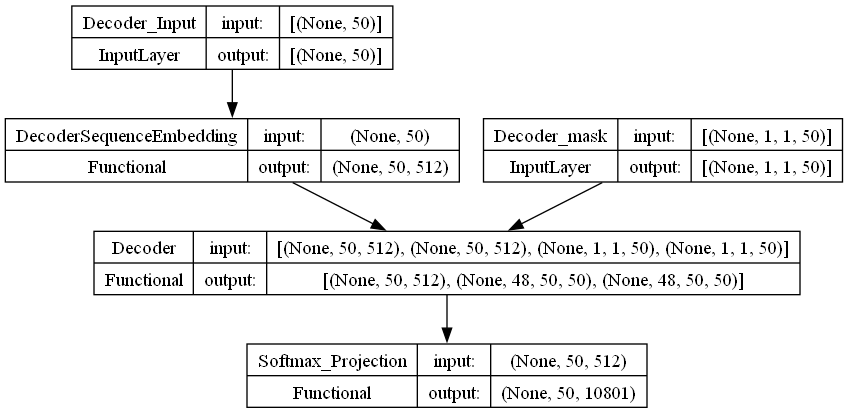

In [28]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [29]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self,training_model,tokenizer=None,input_size=50,output_size=50):
        self.training_model=training_model
        self.tokenizer=tokenizer
        self.input_size=input_size
        self.output_size=output_size

    def on_epoch_end(self,epoch,logs={}):
        self.training_model.save(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/GAN Poetry/results/models/model_{epoch}.h5")
        if (self.tokenizer is not None):
            self.model_evaluate(epoch)

    def model_evaluate(self,epoch=0):
        # Define seed text
        seed_text_init="The world"
        seed_text="The world"
        ones=np.ones((50,))
        next_words=100

        # Iterate and predict each word
        for i in range(next_words):
            # Tokenize seed text
            token_list = self.tokenizer.texts_to_sequences([seed_text])[0]
            # Pad seed text
            token_list = pad_sequences(
                [token_list],
                maxlen=self.output_size,
                padding='pre'
            )
            # Pad Padding
            padding = pad_sequences(
                [ones[:i+2]],
                maxlen=self.output_size,
                padding='pre'
            )
            padding = np.array(padding).reshape(-1,1,1,50)
            # Predict the word
            predicted=tf.math.argmax(self.training_model.predict(
                [token_list,padding],
                verbose=0
            ),axis=-1)
            predicted=np.array([predicted[0][-1]])
            
            # Decode output word
            output_word=self.tokenizer.sequences_to_texts([predicted])[0]
            # Add decoded output word to the seed text
            seed_text+=" " + output_word

        # Extract the output text
        output_text=seed_text.replace(" qq ","\n")
        # Save the extracted output
        if not os.path.exists(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/GAN Poetry/results/logs/epoch_{epoch}/"):
            os.makedirs(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/GAN Poetry/results/logs/epoch_{epoch}/")
        with open(f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/GAN Poetry/results/logs/epoch_{epoch}/transformer_log_epoch_{epoch}.txt","w") as text_file:
            print(f"x:\n{seed_text_init}\ny_hat:\n{output_text}",file=text_file)


callbacks=myCallback(model,tokenizer)

In [32]:
history=model.fit(data_loader(),epochs=90000000000,initial_epoch=56,steps_per_epoch=10000,callbacks=[callbacks])

Epoch 57/90000000000
10000/10000 [==============================] - 3087s 309ms/step - loss: 0.0729 - accuracy: 0.9833
Epoch 58/90000000000
10000/10000 [==============================] - 2967s 297ms/step - loss: 0.0657 - accuracy: 0.9845
Epoch 59/90000000000
10000/10000 [==============================] - 2842s 284ms/step - loss: 0.0644 - accuracy: 0.9847
Epoch 60/90000000000
10000/10000 [==============================] - 2838s 284ms/step - loss: 0.0657 - accuracy: 0.9846
Epoch 61/90000000000
10000/10000 [==============================] - 2838s 284ms/step - loss: 0.0654 - accuracy: 0.9848
Epoch 62/90000000000
10000/10000 [==============================] - 2839s 284ms/step - loss: 0.0678 - accuracy: 0.9841
Epoch 63/90000000000
10000/10000 [==============================] - 2836s 284ms/step - loss: 0.0747 - accuracy: 0.9830
Epoch 64/90000000000
10000/10000 [==============================] - 2839s 284ms/step - loss: 0.0781 - accuracy: 0.9823
Epoch 65/90000000000
10000/10000 [==============

KeyboardInterrupt: 

In [30]:
def inference(seed_text=None,seed_word_length=2,next_words=100,model=model,tokenizer=tokenizer,output_size=50):
    # Define seed text
    seed_text_init=seed_text
    ones=np.ones((50,))
    next_words=next_words

    # Iterate and predict each word
    for i in range(next_words):
        # Tokenize seed text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Pad seed text
        token_list = pad_sequences(
            [token_list],
            maxlen=output_size,
            padding='pre'
        )
        # Pad Padding
        padding = pad_sequences(
            [ones[:i+2]],
            maxlen=output_size,
            padding='pre'
        )
        padding = np.array(padding).reshape(-1,1,1,50)
        # Predict the word
        predicted=tf.math.argmax(model.predict(
            [token_list,padding],
            verbose=0
        ),axis=-1)
        predicted=np.array([predicted[0][-1]])
        
        # Decode output word
        output_word=tokenizer.sequences_to_texts([predicted])[0]
        # Add decoded output word to the seed text
        seed_text+=" " + output_word

    # Extract the output text
    output_text=seed_text.replace(" qq ","\n")
    # Save the extracted output
    print(f"x:\n{seed_text_init}\ny_hat:\n{output_text}")


In [ ]:
model_=transformer.DecoderOnlyTransformer()

In [ ]:
model_.load_weights(filepath=f"C:/Users/Sagar/Python files_Jupiter/Git Repo Local/GAN Poetry/results/models/model_{2}")

In [ ]:
inference(seed_text="soq Compose a poem about nature eoq",seed_word_length=7,next_words=100)

In [ ]:
model.save(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Poetry\results\models\model_temp.h5")